In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import timeit

import pandas as pd
import geopy

# Scrape online data

In [3]:
URL = 'https://www.beeradvocate.com/beer/profile/2958/87869/'
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')


In [50]:
res = soup.find(id='info_box')

In [16]:
beerstats = soup.find_all(class_='beerstats')

In [32]:
bold = res.find_all('b')

In [33]:
bold

[<b>Beer Geek Stats:</b>,
 <b>Style:</b>,
 <b>Belgian Saison</b>,
 <b>ABV:</b>,
 <b>5%</b>,
 <b>Score:</b>,
 <b>94</b>]

In [57]:
soup.find(title="Learn more about this style.").find('b').text

'Belgian Saison'

In [65]:
soup.find_all(title="Percentage of alcohol by volume.")[-1].find('b').text[:-1]

'5'

In [55]:
soup.find(class_="ba-score Tooltip").text

'94'

In [54]:
soup.find(class_="ba-ravg Tooltip").text

'4.26'

In [60]:
soup.find(title="View more beers and info from this brewery.").text

'BFM (Brasserie des Franches-Montagnes)'

In [64]:
soup.find_all(href=lambda x: x and x.startswith('/place/directory/'))[-1].text

'Switzerland'

In [75]:
soup.find(class_="titleBar")

<div class="titleBar">
<h1>XV (√225 Saison)<br/><span style="color:#999999; font-size:0.75em;">BFM (Brasserie des Franches-Montagnes)</span></h1>
</div>

In [81]:
soup.find('title').text.split('|')[0].strip()

'XV (√225 Saison)'

In [94]:
def parse_beer_page(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    name = soup.find('title').text.split('|')[0].strip()
    style = soup.find(title="Learn more about this style.").find('b').text
    alc_perc = float(soup.find_all(title="Percentage of alcohol by volume.")[-1].find('b').text[:-1])
    
    score_temp = soup.find(class_="ba-score Tooltip")
    if score_temp is not None:
        score = float(score_temp.text)
    else: score = np.NaN
    rating = float(soup.find(class_="ba-ravg Tooltip").text)
    brewery = soup.find(title="View more beers and info from this brewery.").text
    country = soup.find_all(href=lambda x: x and x.startswith('/place/directory/'))[-1].text
    
    return dict(name=name, style=style, alc_perc=alc_perc, 
                score=score, rating=rating, brewery=brewery, country=country)
    

In [165]:
def get_beer_country(url, session=requests):
    try:
        page = session.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        country = soup.find_all(href=lambda x: x and x.startswith('/place/directory/'))[-1].text
    except:
        country = ''
    return country

In [99]:
parse_beer_page('https://www.beeradvocate.com/beer/profile/2385/87878/')

{'name': 'Dark Ale',
 'style': 'American Brown Ale',
 'alc_perc': 4.0,
 'score': nan,
 'rating': 3.44,
 'brewery': 'Black Duck Brewery',
 'country': 'Australia'}

In [106]:
get_beer_country('https://www.beeradvocate.com/beer/profile/2/3/')

'United States'

In [109]:
countries = []
url = 'https://www.beeradvocate.com/beer/profile/2/{}/'
for i in range(100):
    try:
        countries.append(get_beer_country(url.format(i)))
    except:
        print(i)
    

1
2
22
25
53
57
60
64
70
77
91
98


In [167]:
s = requests.Session()
timeit.timeit(lambda: get_beer_country(url.format(15002),s), number=5)

3.777793766999821

In [146]:
timeit.timeit(lambda: requests.head(url.format(19)), number=1)

0.8501878259994555

In [147]:
requests.head(url.format(19))

<Response [301]>

In [149]:
1.5* 100000 / 3600

41.666666666666664

## Check parallel requests

In [160]:
import eventlet

urls = [url.format(i) for i in range(50)]
pool = eventlet.GreenPool(50)

countries = []
def pool_work():
    for country in pool.imap(get_beer_country, urls):
        countries.append(country)
        print('one is done')

timeit.timeit(pool_work, number=1)

one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done


60.20601609700043

In [154]:
urls

['https://www.beeradvocate.com/beer/profile/2/3/',
 'https://www.beeradvocate.com/beer/profile/2/4/',
 'https://www.beeradvocate.com/beer/profile/2/5/',
 'https://www.beeradvocate.com/beer/profile/2/6/',
 'https://www.beeradvocate.com/beer/profile/2/7/',
 'https://www.beeradvocate.com/beer/profile/2/8/',
 'https://www.beeradvocate.com/beer/profile/2/9/',
 'https://www.beeradvocate.com/beer/profile/2/10/',
 'https://www.beeradvocate.com/beer/profile/2/11/',
 'https://www.beeradvocate.com/beer/profile/2/12/',
 'https://www.beeradvocate.com/beer/profile/2/13/',
 'https://www.beeradvocate.com/beer/profile/2/14/',
 'https://www.beeradvocate.com/beer/profile/2/15/',
 'https://www.beeradvocate.com/beer/profile/2/16/',
 'https://www.beeradvocate.com/beer/profile/2/17/',
 'https://www.beeradvocate.com/beer/profile/2/18/',
 'https://www.beeradvocate.com/beer/profile/2/19/',
 'https://www.beeradvocate.com/beer/profile/2/20/',
 'https://www.beeradvocate.com/beer/profile/2/21/',
 'https://www.beera

In [169]:
from concurrent.futures import ThreadPoolExecutor
from requests_futures.sessions import FuturesSession

session = FuturesSession(max_workers=5)
cs = []
timeit.timeit(lambda: cs.append(get_beer_country(url.format(15002),session)), number=5)

0.007156055999985256

In [172]:
cs

['', '', '', '', '']

In [175]:
from concurrent.futures import as_completed
from requests_futures.sessions import FuturesSession

def get_beer_countries_parall(urls):
    countries = []
    session = FuturesSession(max_workers=5)
    
    futures = [session.get(url) for url in urls]
    for future in as_completed(futures):
        try:
            resp = future.result()
            soup = BeautifulSoup(resp.content, 'html.parser')
            country = soup.find_all(href=lambda x: x and x.startswith('/place/directory/'))[-1].text
            countries.append(country)
        except:
            pass
    
    return countries

In [187]:
def get_swiss_beers_parall(urls):
    swissbeers = []
    session = FuturesSession(max_workers=5)
    
    futures = [session.get(url) for url in urls]
    for future in as_completed(futures):
        try:
            resp = future.result()
            soup = BeautifulSoup(resp.content, 'html.parser')
            country = soup.find_all(href=lambda x: x and x.startswith('/place/directory/'))[-1].text
            if country == 'Switzerland':
                swissbeers.append(resp.url)
        except:
            pass
    
    return swissbeers

In [176]:
urls = [url.format(i) for i in range(50)]

timeit.timeit(lambda: get_beer_countries_parall(urls), number=1)

6.967507653000212

In [184]:
session = FuturesSession(max_workers=5)

future = session.get(url.format(19))

In [185]:
resp = future.result()

In [186]:
resp.url

'https://www.beeradvocate.com/beer/profile/9/19/'

In [188]:
swiss_beers_urls = get_swiss_beers_parall([url.format(i) for i in range(1000)])

In [189]:
swiss_beers_urls

[]

In [191]:
460000 * (7/50)

64400.00000000001

In [194]:
30*60/(7/50)

12857.142857142855

In [195]:
swiss_beers_urls_to12k = get_swiss_beers_parall([url.format(i) for i in range(12000)])

KeyboardInterrupt: 

## Login to BeerAdvocate

In [275]:
s = requests.Session()
url_login = 'https://www.beeradvocate.com/community/login/login'
with open('ba_credentials','r') as f:
    login, password = f.read().splitlines()

In [276]:
 
payload = {'login': login, 'password': password}
page = s.post(url_login, data=payload)

In [277]:
with open('test.html','bw') as f:
    f.write(page.content)

In [10]:
url_ch = 'https://www.beeradvocate.com/place/list/?c_id=CH&s_id=0&brewery=Y'
url_ch2 = 'https://www.beeradvocate.com/place/list/?start=20&&c_id=CH&brewery=Y&sort=name'
ch_page1 = s.get(url_ch)

In [278]:
url_ch_gen = 'https://www.beeradvocate.com/place/list/?start={}&&c_id=CH&brewery=Y&sort=name'

In [281]:
ch_end = s.get(url_ch_gen.format(140))
soup_ch_end = BeautifulSoup(ch_end.content)
list_ch_end = soup_ch_end.find_all(href=lambda x: x and x.startswith('/beer/profile/'))
list_ch_end

[]

In [274]:
with open('test2.html','bw') as f:
    f.write(ch_end.content)

In [258]:
len(list_ch_end)

0

## List all CH breweries

In [298]:
base_url = 'https://www.beeradvocate.com'
def brewery_extract(row):
    cols = row.find_all('td')
    first_el = cols[0].find('a')
    link = base_url +first_el['href']
    brewery_name = first_el.text
    def treat_dash(text):
        if text=='-':
            return 'nan'
        else:
            return text
    ratings, nbeers = [treat_dash(x.text) for x in cols[-2:]]
    ratings = float(ratings)
    nbeers = int(nbeers)
    dic = dict(
        name = brewery_name, link = link,
        ratings = ratings, n_beers = nbeers
        )
    return dic
    

In [299]:
def treat_address(list_ad):
    ad = ''
    for el in list_ad:
        if el.name == 'br':
            ad += '\n'
        elif el.name == 'a':
            ad += el.get_text()
        else:
            ad += str(el).strip()
    ad = ad.split('\n\n')
    ad = list(map(lambda x: x.strip(), ad))
    if len(ad) == 2:
        address, tel = ad
    else:
        address = ad[0]
        tel = ''
    return dict(address=address, telephone=tel)

In [302]:
def breweries_from_page(page):
    table_rows = iter(page.find('table').find_all('tr'))
    breweries = []
    for row in table_rows:
        #columns = row.find_all('td')
        #table.append([el.text.rstrip() for el in columns])
        if row.find(href=lambda x: x and x.startswith('/beer/profile/')):
            brew_dic = brewery_extract(row)
            address_row = next(table_rows).find('td')
            list_ad = list(address_row.children)
            brew_dic.update(treat_address(list_ad))
            breweries.append(brew_dic)
    return breweries

In [303]:
s = requests.Session()
url_login = 'https://www.beeradvocate.com/community/login/login'

with open('ba_credentials','r') as f:
    login, password = f.read().splitlines() 
payload = {'login': login, 'password': password}
page = s.post(url_login, data=payload)

url_ch_gen = 'https://www.beeradvocate.com/place/list/?start={}&&c_id=CH&brewery=Y&sort=name'
start_n = 0
search = True
breweries_ch = []
while search:
    brew_page = BeautifulSoup(s.get(url_ch_gen.format(start_n)).content)
    more_breweries = brew_page.find_all(href=lambda x: x and x.startswith('/beer/profile/'))
    if len(more_breweries) >0 :
        breweries_ch += breweries_from_page(brew_page)
    else:
        search=False
    
    start_n += 20
    print(start_n)
    


20
40
60
80
100
120
140
160


In [304]:
breweries_ch_df = pd.DataFrame(breweries_ch)

In [305]:
breweries_ch_df

,name,link,ratings,n_beers,address,telephone
0,4655 Brewing Company,https://www.beeradvocate.com/beer/profile/41488/,NaN,4,"Stüsslingen, 4655\nSwitzerland",
1,523,https://www.beeradvocate.com/beer/profile/44206/,3.79,2,"Sonnenweg 30\nKöniz, 3098\nSwitzerland",+41 77 450 7655
2,7Peaks Brasserie,https://www.beeradvocate.com/beer/profile/39040/,2.72,9,"Route de la Patinoire 15a\nMorgins, 1875\nSwit...",+41 78 797 1875
3,À tue-tête,https://www.beeradvocate.com/beer/profile/52843/,4.14,9,"Chemin de la Biole 10\nAigle, 1860\nSwitzerland",+41 79 235 56 49
4,Ahoi Bier,https://www.beeradvocate.com/beer/profile/42305/,3.67,4,"Schlieren, 8952,Switzerland",
...,...,...,...,...,...,...
135,Volta Bräu,https://www.beeradvocate.com/beer/profile/39036/,NaN,2,"Voltastrasse 30\nBasel, 4056\nSwitzerland",+41 61 690 91 29
136,Wadi-Brau-Huss AG,https://www.beeradvocate.com/beer/profile/9378/,NaN,0,"Florhofstrasse 13\nWadenswill, 8820\nSwitzerland",01 783 9392
137,Wartauer Seegal Bräu,https://www.beeradvocate.com/beer/profile/39074/,NaN,8,"Hauptstrasse 33/35\nTrübbach, 9477\nSwitzerland",+41 78 878 19 52
138,Weedbeer,https://www.beeradvocate.com/beer/profile/32639/,3.00,1,"Chemin de l'Etraz 14\nOrbe, 1350\nSwitzerland",+41 21 312 68 21


## Data exploration

In [337]:
breweries_ch_df.sort_values('n_beers', ascending=False).dropna()

,name,link,ratings,n_beers,address,telephone
40,Brasserie Trois Dames,https://www.beeradvocate.com/beer/profile/17998/,3.80,39,"Rue de France 1\nSainte-Croix, 1450\nSwitzerland",+41 24 454 4375
85,Feldschlösschen Beverages Group,https://www.beeradvocate.com/beer/profile/555/,2.96,28,"Theophil-Roniger-Strasse\nRheinfelden, 4310\nS...",+41 (0)61 833 48 48
57,Brauerei Locher AG,https://www.beeradvocate.com/beer/profile/5687/,3.58,24,"Brauereiplatz\nAppenzell, 9050\nSwitzerland",0041 71 787 13 18
12,BFM (Brasserie des Franches-Montagnes),https://www.beeradvocate.com/beer/profile/2958/,4.16,23,"Chemin des Buissons 8\nSaignelégier, 2350\nSwi...",+41 32 951 26 26
18,Birrificio Ticinese,https://www.beeradvocate.com/beer/profile/24571/,3.53,15,"Via Vite 5\nStabio, 6855\nSwitzerland",+41 (0)91 695 41 90
...,...,...,...,...,...,...
133,UHB,https://www.beeradvocate.com/beer/profile/47229/,3.50,1,"Pestalozzistrasse 70\nBurgdorf, 3400\nSwitzerland",+41 079 345 03 20
61,Brauerei Stadtguet,https://www.beeradvocate.com/beer/profile/21378/,3.99,1,"Industriestrasse 35\nWinterthur, 8404\nSwitzer...",079 784 96 22
69,Bun Tschlin,https://www.beeradvocate.com/beer/profile/44230/,3.59,1,"Mierta Rainolter\nTschlin, 7559\nSwitzerland",41 81 866 31 07
6,All Bar One,https://www.beeradvocate.com/beer/profile/32419/,3.65,1,"Steinenvorstadt 37\nBasel, 4051\nSwitzerland",+41 61 281 87 00


## Find geographical coordinates of breweries

In [37]:
from  geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent='beer-scraper')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.5)

def address_to_coordinates(ad):
    ad_com = ad.replace('\n',', ')
    loc = geocode(ad_com)
    if loc is None:
        partial_ad = ', '.join(ad.split('\n')[1:])
        loc = geocode(partial_ad)
        if loc is None:
            return float('nan'), float('nan')
    return loc.latitude, loc.longitude

In [309]:
breweries_ch_df['address'][17]

'Via Sotto Bisio 3A\nBalerna, 6828\nSwitzerland'

In [330]:
from  geopy.geocoders import Nominatim
geolocator = Nominatim()
loc = geolocator.geocode(address)
#print("latitude is :-" ,loc.latitude,"\nlongtitude is:-" ,loc.longitude)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [362]:
address = breweries_ch_df['address'][50]

In [329]:
address

'Obergrundstrasse 110, Luzern, 6002, Switzerland'

In [322]:
loc

Location(Birrificio Sottobisio, 3A, Via Sotto Bisio, Bisio, Balerna, Circolo di Balerna, Distretto di Mendrisio, Ticino, 6828, Switzerland, (45.8443345, 9.0078042, 0.0))

In [331]:
loc.latitude, loc.longitude

(47.04039495, 8.297661748848313)

In [35]:
breweries_ch_df.loc[5]

name                         Aktienbrauerei Flims Surselva AG
link         https://www.beeradvocate.com/beer/profile/20175/
ratings                                                  4.03
n_beers                                                     1
address           Waldhaus\nFlims Waldhaus, 7018\nSwitzerland
telephone                                     41 81 928 14 00
latitude                                              46.8273
longitude                                             9.28622
Name: 5, dtype: object

In [34]:
address_to_coordinates(breweries_ch_df['address'][5])

(46.827296700000005, 9.286218266858235)

In [349]:
breweries_ch_df['address'][2].replace('\n', ', ')

'Route de la Patinoire 15a, Morgins, 1875, Switzerland'

In [38]:
breweries_ch_df["latitude"], breweries_ch_df["longitude"] = zip(
    *breweries_ch_df["address"].map(address_to_coordinates))

In [358]:
loc = geolocator.geocode('7Peaks')

In [360]:
loc is None

True

In [367]:
', '.join(address.split('\n')[1:])

'Luzern, 6002, Switzerland'

In [30]:
# Try google maps
import geopy.geocoders as geocoders
#geolocator = Nominatim(user_agent='beer-scraper')
geolocator = geocoders.OpenMapQuest(user_agent='beer-scraper')

loc = geolocator.geocode('Route de Bas-Vièze 83, 1875 Morgins, Switzerland', timeout=5)
#loc = geolocator.geocode('Morgins, Switzerland', timeout=5)
loc

ConfigurationError: OpenMapQuest requires an API key

In [31]:
from geopy.geocoders import GoogleV3
geolocator = GoogleV3()
address, (latitude, longitude) = geolocator.geocode("175 5th Avenue NYC")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Since July 2018 Google requires each request to have an API key. Pass a valid `api_key` to GoogleV3 geocoder to hide this warning. See https://developers.google.com/maps/documentation/geocoding/usage-and-billing
  


GeocoderQueryError: Your request was denied.

In [62]:
# Fixing missing coordinates by hand
breweries_ch_df[breweries_ch_df['latitude'].isna()]

,name,link,ratings,n_beers,address,telephone,latitude,longitude
95,Il Fermento,https://www.beeradvocate.com/beer/profile/58104/,NaN,0,"Via Marconi 2\nPalazzi Gargantini\nLugano, 690...",+41 (0) 91 923 45 45,NaN,NaN
126,Steinfels,https://www.beeradvocate.com/beer/profile/21242/,3.17,4,"Heinrichstrasse 267\nEcher Wyss Platz\nZürich,...",41 (0)44 271 10 30,NaN,NaN
136,Wadi-Brau-Huss AG,https://www.beeradvocate.com/beer/profile/9378/,NaN,0,"Florhofstrasse 13\nWadenswill, 8820\nSwitzerland",01 783 9392,NaN,NaN


In [73]:
breweries_ch_df.loc[136]['address']

'Florhofstrasse 13\nWadenswill, 8820\nSwitzerland'

In [78]:
loc = address_to_coordinates('Florhofstrasse 9, 8820 Wädenswil')
loc

(47.2308218, 8.6695479)

In [80]:
ind = 136
#breweries_ch_df.loc[ind,'latitude'], breweries_ch_df.loc[ind, 'longitude'] = loc

In [61]:
breweries_ch_df.loc[ind]

name                                            Engadiner Bier
link          https://www.beeradvocate.com/beer/profile/44231/
ratings                                                   3.59
n_beers                                                      3
address      Via Da la Staziun 51\nPostfach 110\nPontresina...
telephone                                     +41 81 842 68 31
latitude                                               46.4913
longitude                                              9.89583
Name: 82, dtype: object

## Save pandas DataFrame

In [83]:
breweries_ch_df.to_pickle('breweries_ch_pickled')

In [6]:
# read pickle

breweries_ch_df = pd.read_pickle('breweries_ch_pickled')

In [85]:
breweries_ch_df

,name,link,ratings,n_beers,address,telephone,latitude,longitude
0,4655 Brewing Company,https://www.beeradvocate.com/beer/profile/41488/,NaN,4,"Stüsslingen, 4655\nSwitzerland",,47.392886,7.971289
1,523,https://www.beeradvocate.com/beer/profile/44206/,3.79,2,"Sonnenweg 30\nKöniz, 3098\nSwitzerland",+41 77 450 7655,46.925468,7.416251
2,7Peaks Brasserie,https://www.beeradvocate.com/beer/profile/39040/,2.72,9,"Route de la Patinoire 15a\nMorgins, 1875\nSwit...",+41 78 797 1875,46.237659,6.858102
3,À tue-tête,https://www.beeradvocate.com/beer/profile/52843/,4.14,9,"Chemin de la Biole 10\nAigle, 1860\nSwitzerland",+41 79 235 56 49,46.309735,6.944491
4,Ahoi Bier,https://www.beeradvocate.com/beer/profile/42305/,3.67,4,"Schlieren, 8952,Switzerland",,47.396515,8.444486
...,...,...,...,...,...,...,...,...
135,Volta Bräu,https://www.beeradvocate.com/beer/profile/39036/,NaN,2,"Voltastrasse 30\nBasel, 4056\nSwitzerland",+41 61 690 91 29,47.570967,7.579546
136,Wadi-Brau-Huss AG,https://www.beeradvocate.com/beer/profile/9378/,NaN,0,"Florhofstrasse 13\nWadenswill, 8820\nSwitzerland",01 783 9392,47.230822,8.669548
137,Wartauer Seegal Bräu,https://www.beeradvocate.com/beer/profile/39074/,NaN,8,"Hauptstrasse 33/35\nTrübbach, 9477\nSwitzerland",+41 78 878 19 52,47.073017,9.480788
138,Weedbeer,https://www.beeradvocate.com/beer/profile/32639/,3.00,1,"Chemin de l'Etraz 14\nOrbe, 1350\nSwitzerland",+41 21 312 68 21,46.720308,6.539114


## Bubble map

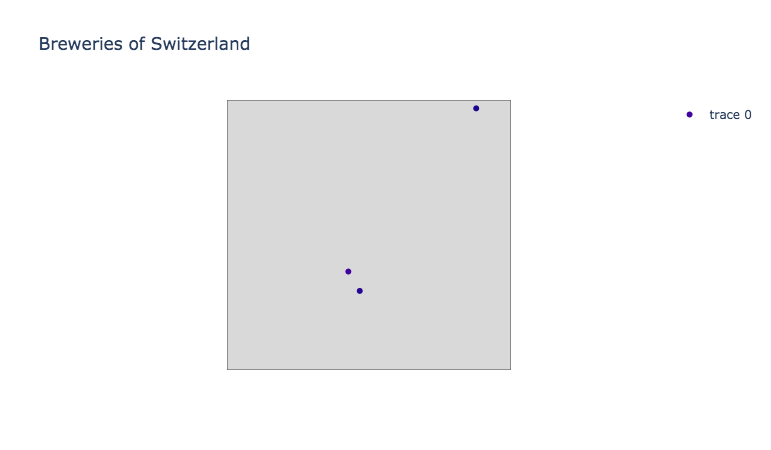

In [36]:
fig = go.Figure(data=go.Scattergeo(
        lon = breweries_ch_df['longitude'],
        lat = breweries_ch_df['latitude'],
        text = breweries_ch_df['name'],
        mode = 'markers',
        marker_color = breweries_ch_df['n_beers'],
        ))
fig.update_layout(
        title_text = 'Breweries of Switzerland',
        showlegend = True,
        geo = dict(
            scope = 'europe',
            landcolor = 'rgb(217, 217, 217)',
        )
    )
fig.show()

## Mapbox

In [31]:
breweries_ch_df[breweries_ch_df['name'].apply(lambda s: 'Hoppy' in s)]

,name,link,ratings,n_beers,address,telephone,latitude,longitude
93,Hoppy People,https://www.beeradvocate.com/beer/profile/48536/,3.76,10,"Route Des Sablons 11\nSierre, 3960\nSwitzerland",+41 (0)27 455-00 00,47.050545,8.305468


In [32]:
breweries_ch_df[breweries_ch_df['name'].apply(lambda s: '7Peaks' in s)]

,name,link,ratings,n_beers,address,telephone,latitude,longitude
2,7Peaks Brasserie,https://www.beeradvocate.com/beer/profile/39040/,2.72,9,"Route de la Patinoire 15a\nMorgins, 1875\nSwit...",+41 78 797 1875,47.050545,8.305468


In [86]:
import plotly.express as px
import plotly.offline as py
px.set_mapbox_access_token(open(".mapbox_token").read())

fig = px.scatter_mapbox(breweries_ch_df, 
                        lat="latitude", lon="longitude",     
                        color="ratings", size="n_beers",
                        text='name',
                  color_continuous_scale=px.colors.sequential.Viridis, 
                        size_max=15, zoom=6)
#fig.show()
py.plot(fig, filename='swiss-breweries-map.html')

'swiss-breweries-map.html'

## Selecting items on map

In [7]:
import plotly.graph_objs as go
from ipywidgets import Output, VBox
import plotly.express as px


map = px.scatter_mapbox(breweries_ch_df, 
                        lat="latitude", lon="longitude",     
                        color="ratings", size="n_beers",
                        text='name',
                  color_continuous_scale=px.colors.sequential.Viridis, 
                        size_max=15, zoom=6)
fig = go.FigureWidget(map)

out = Output()
@out.capture(clear_output=True)
def handle_click(trace, points, state):
    print(points.point_inds)

#pie.on_click(handle_click)
fig.data[0].on_click(handle_click)

VBox([fig, out])

    'data': [{'hoverlabel': {'namelength': 0},
              'hovertemplate': ('…